In [15]:
from gplearn.genetic import SymbolicRegressor
import os
import pandas as pd
import random
import numpy as np

optimized_regressor = SymbolicRegressor(population_size=200,
                                        generations=200, stopping_criteria=0.01,
                                        init_depth=(2, 5),
                                        optimize_constants=True,
                                        p_crossover=0.7, p_subtree_mutation=0.1,
                                        p_hoist_mutation=0.05, p_point_mutation=0.1,
                                        max_samples=0.9, verbose=0,
                                        parsimony_coefficient=0.01, random_state=42)

# Best parameters found:
# {'population_size': 500, 'generations': 20, 'tournament_size': 10, 'stopping_criteria': 0.01, 'init_depth': (2, 4), 'parsimony_coefficient': 0.01, 'max_samples': 0.9, optimized_constants: True}
# Best mean R² score: 0.15448339849810716
hyper_optimized_regressor = SymbolicRegressor(population_size=500,
                                              tournament_size=10,
                                              generations=20, stopping_criteria=0.01,
                                              init_depth=(2, 4),
                                              optimize_constants=True,
                                              p_crossover=0.7, p_subtree_mutation=0.1,
                                              p_hoist_mutation=0.05, p_point_mutation=0.1,
                                              max_samples=0.9, verbose=0,
                                              parsimony_coefficient=0.01, random_state=42)

# 'population_size': 500, 'generations': 20, 'tournament_size': 10, 'stopping_criteria': 0.01, 'init_depth': (2, 4), 'parsimony_coefficient': 0.01, 'max_samples': 0.9
hyper_default_regressor = SymbolicRegressor(population_size=500,
                                            tournament_size=10,
                                            generations=20, stopping_criteria=0.01,
                                            init_depth=(2, 4),
                                            p_crossover=0.7, p_subtree_mutation=0.1,
                                            p_hoist_mutation=0.05, p_point_mutation=0.1,
                                            max_samples=0.9, verbose=0,
                                            parsimony_coefficient=0.01, random_state=42)

default_regressor = SymbolicRegressor(population_size=5000,
                                      generations=20, stopping_criteria=0.01,
                                      init_depth=(2, 6),
                                      p_crossover=0.7, p_subtree_mutation=0.1,
                                      p_hoist_mutation=0.05, p_point_mutation=0.1,
                                      max_samples=0.9, verbose=0,
                                      parsimony_coefficient=0.01, random_state=0)


dataset_folder = "Virtual_Dataset/Virtual_Dataset"
files = os.listdir(dataset_folder)
# Filter out files with NaN values before sampling
valid_files = []
for file_path in files:
    df = pd.read_csv(os.path.join(dataset_folder, file_path))
    X = df.iloc[:, :-1]
    if not np.isnan(X.values).any():
        valid_files.append(file_path)

# Select a subset of valid files for tuning
tune_files = random.sample(valid_files, min(25, len(valid_files)))


In [16]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import time
import numpy as np
import warnings

def process_file(file_path):
    """Process a single dataset file, handling NaN errors."""
    global counter
    with counter_lock:
        counter.value += 1
        file_number = counter.value
    print(f"Processing file {file_number}: {file_path}")

    file_full_path = os.path.join(dataset_folder, file_path)
    df = pd.read_csv(file_full_path)

    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            
            # optimized regressor
            start_time = time.time()
            hyper_optimized_regressor.fit(X_train, y_train)
            optimized_time = time.time() - start_time
            optimized_score = hyper_optimized_regressor.score(X_test, y_test)

            # default regressor
            start_time = time.time()
            hyper_default_regressor.fit(X_train, y_train)
            default_time = time.time() - start_time
            default_score = hyper_default_regressor.score(X_test, y_test)

    except ValueError as e:
        if "NaN" in str(e):
            print(f"Skipping file due to NaN values: {file_path}")
            optimized_time = optimized_score = default_time = default_score = np.nan
        else:
            # propagate other errors
            raise e

    return {
        "file_name": file_path,
        "optimized_time": optimized_time,
        "optimized_score": optimized_score,
        "default_time": default_time,
        "default_score": default_score
    }

In [17]:
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count, Value, Lock

counter = Value('i', 0)  # 'i' = integer
counter_lock = Lock()

if __name__ == "__main__":
    # Use all available CPU cores
    with Pool(cpu_count()) as pool:
        results_list = pool.map(process_file, files)

    # Combine results into a big DataFrame
    hyper_big_df = pd.DataFrame(results_list).set_index("file_name")
    print(hyper_big_df)


Processing file 2: Virtual_Dataset37.csvProcessing file 7: Virtual_Dataset5.csvProcessing file 9: Virtual_Dataset39.csvProcessing file 3: VirtualDataset53.csvProcessing file 10: Virtual_Dataset7.csvProcessing file 11: VirtualDataset57.csv
Processing file 5: Virtual_Dataset31.csvProcessing file 4: VirtualDataset90.csvProcessing file 12: Virtual_Dataset20.csvProcessing file 6: Virtual_Dataset14.csvProcessing file 15: VirtualDataset58.csvProcessing file 14: VirtualDataset76.csv
Processing file 1: Virtual_Dataset22.csv

Processing file 8: VirtualDataset87.csvProcessing file 13: VirtualDataset45.csv








Processing file 16: VirtualDataset85.csv


Processing file 17: VirtualDataset80.csv
Processing file 18: Virtual_Dataset10.csv
Processing file 19: Virtual_Dataset8.csv
Processing file 20: VirtualDataset97.csv
Processing file 21: VirtualDataset88.csv
Processing file 22: Virtual_Dataset24.csv
Processing file 23: VirtualDataset96.csv
Processing file 24: VirtualDataset66.csv
Processing file 2

In [18]:
# save big_df to csv
hyper_big_df.to_csv("hyer_default_vs_hyper_optimized.csv")

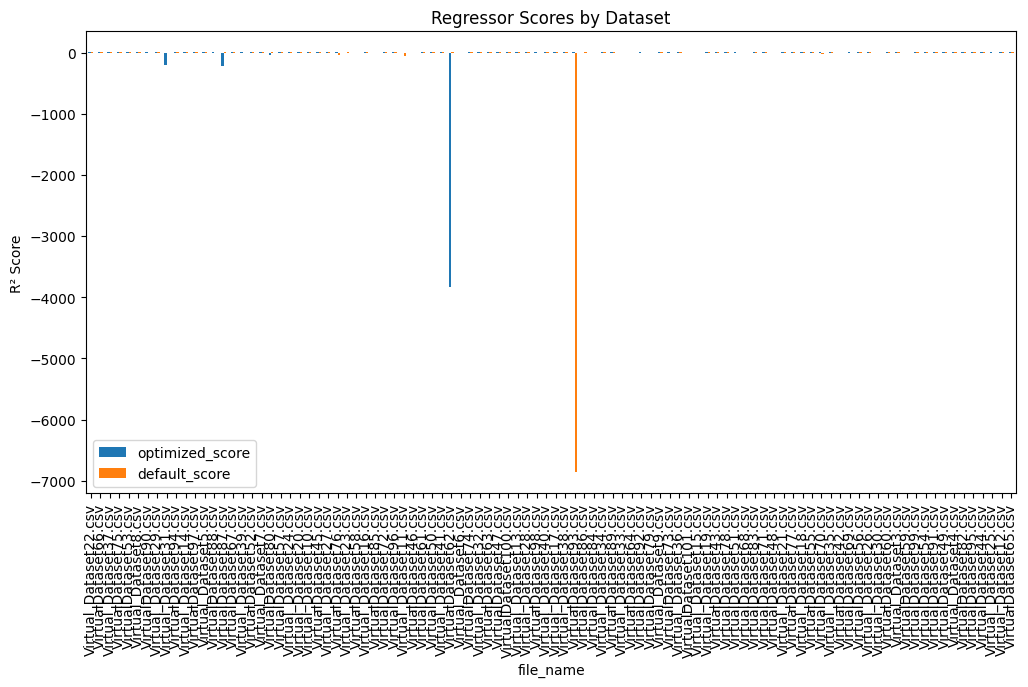

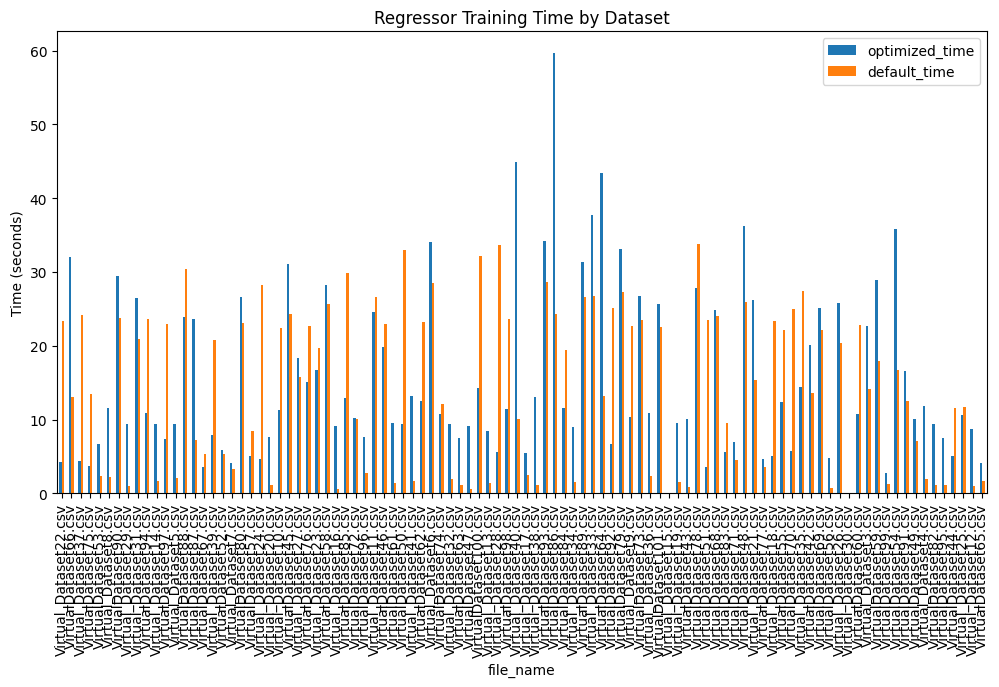

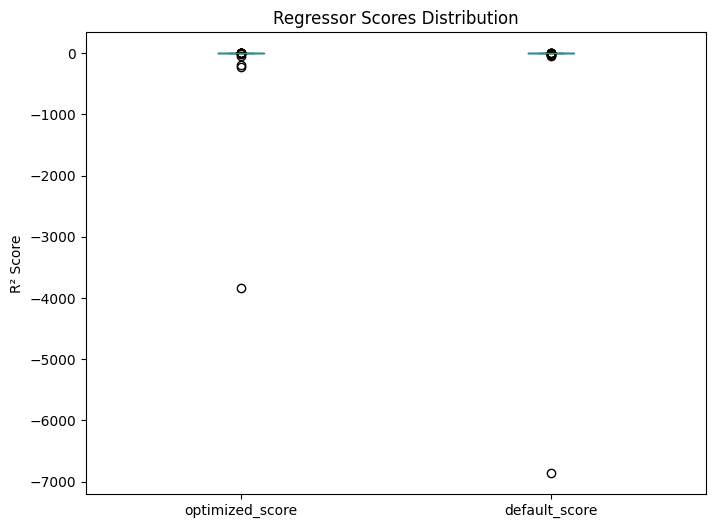

In [19]:
hyper_big_df = pd.read_csv("hyer_default_vs_hyper_optimized.csv", index_col="file_name")

# Visualization
hyper_big_df[["optimized_score", "default_score"]].plot(
    kind="bar", figsize=(12,6), title="Regressor Scores by Dataset"
)
plt.ylabel("R² Score")
plt.show()

hyper_big_df[["optimized_time", "default_time"]].plot(
    kind="bar", figsize=(12,6), title="Regressor Training Time by Dataset"
)
plt.ylabel("Time (seconds)")
plt.show()

# boxplot
hyper_big_df[["optimized_score", "default_score"]].plot(
    kind="box", figsize=(8,6), title="Regressor Scores Distribution"
)
plt.ylabel("R² Score")
plt.show()


In [20]:
optimized_scores = hyper_big_df['optimized_score']
default_scores = hyper_big_df['default_score']
optimized_times = hyper_big_df['optimized_time']
default_times = hyper_big_df['default_time']

# top 5 scores
top_5_optimized = optimized_scores.nlargest(5)
top_5_default = default_scores.nlargest(5)

# bottom 5 scores
bottom_5_optimized = optimized_scores.nsmallest(10)
bottom_5_default = default_scores.nsmallest(10)

# top 5 times
top_5_time_optimized = optimized_times.nlargest(5)
top_5_time_default = default_times.nlargest(5)

# bottom 5 times
bottom_5_time_optimized = optimized_times.nsmallest(5)
bottom_5_time_default = default_times.nsmallest(5)

# print("Top 5 Optimized Scores:")
# print(top_5_optimized.to_string(), "\n")

# print("Top 5 Default Scores:")
# print(top_5_default.to_string(), "\n")

print("Bottom 5 Optimized Scores:")
print(bottom_5_optimized.to_string(), "\n")

print("Bottom 5 Default Scores:")
print(bottom_5_default.to_string(), "\n")

# print("Top 5 Optimized Training Times:")
# print(top_5_time_optimized.to_string(), "\n")

# print("Top 5 Default Training Times:")
# print(top_5_time_default.to_string(), "\n")

# print("Bottom 5 Optimized Training Times:")
# print(bottom_5_time_optimized.to_string(), "\n")

# print("Bottom 5 Default Training Times:")
# print(bottom_5_time_default.to_string(), "\n")

Bottom 5 Optimized Scores:
file_name
VirtualDataset62.csv    -3831.317692
VirtualDataset87.csv     -225.875305
Virtual_Dataset31.csv    -200.657265
VirtualDataset80.csv      -44.293724
VirtualDataset68.csv       -9.134252
VirtualDataset85.csv       -4.070842
VirtualDataset84.csv       -4.070842
VirtualDataset64.csv       -3.257922
VirtualDataset42.csv       -1.619225
Virtual_Dataset33.csv      -1.589629 

Bottom 5 Default Scores:
file_name
VirtualDataset93.csv    -6862.784825
Virtual_Dataset11.csv     -50.504753
VirtualDataset76.csv      -37.554148
VirtualDataset70.csv      -29.760951
VirtualDataset98.csv      -14.872434
VirtualDataset68.csv       -7.057675
Virtual_Dataset31.csv      -4.123674
VirtualDataset92.csv       -3.698135
VirtualDataset85.csv       -2.365029
VirtualDataset84.csv       -2.365029 



Dropped 19 datasets due to negative scores in optimized optimization.
Dropped 23 datasets due to negative scores in default optimization.
Mean Optimized Score (after filtering): 0.9480 ± 0.1496
Mean Default Score (after filtering): 0.8986 ± 0.2456


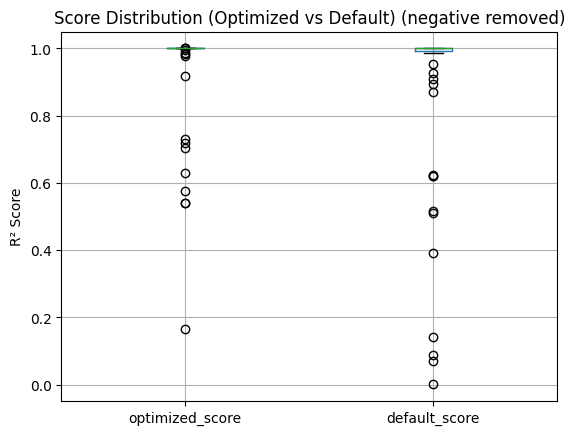

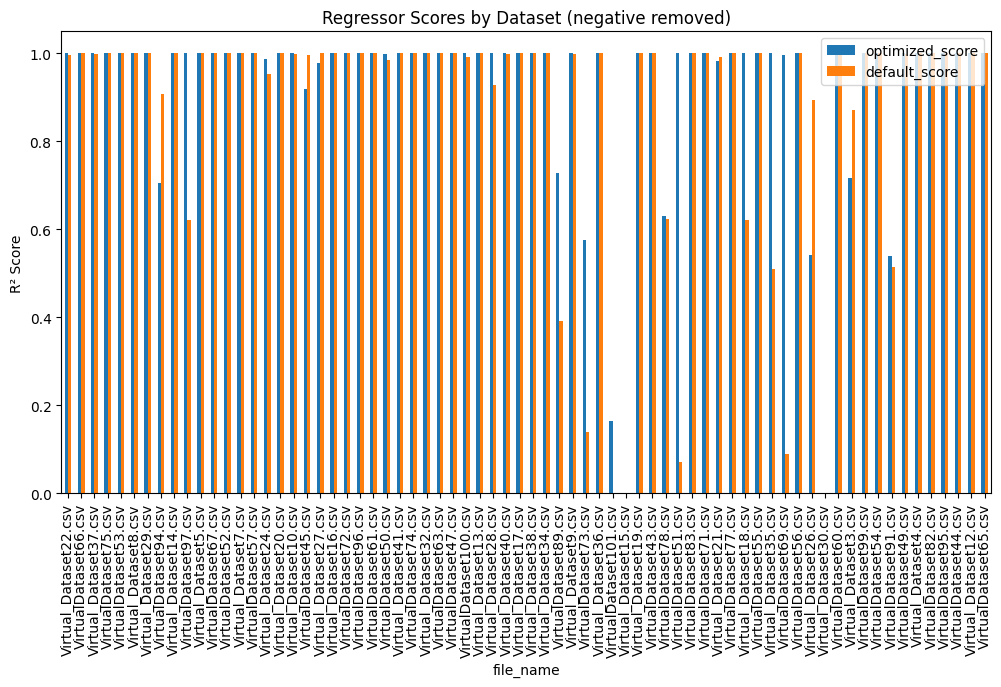

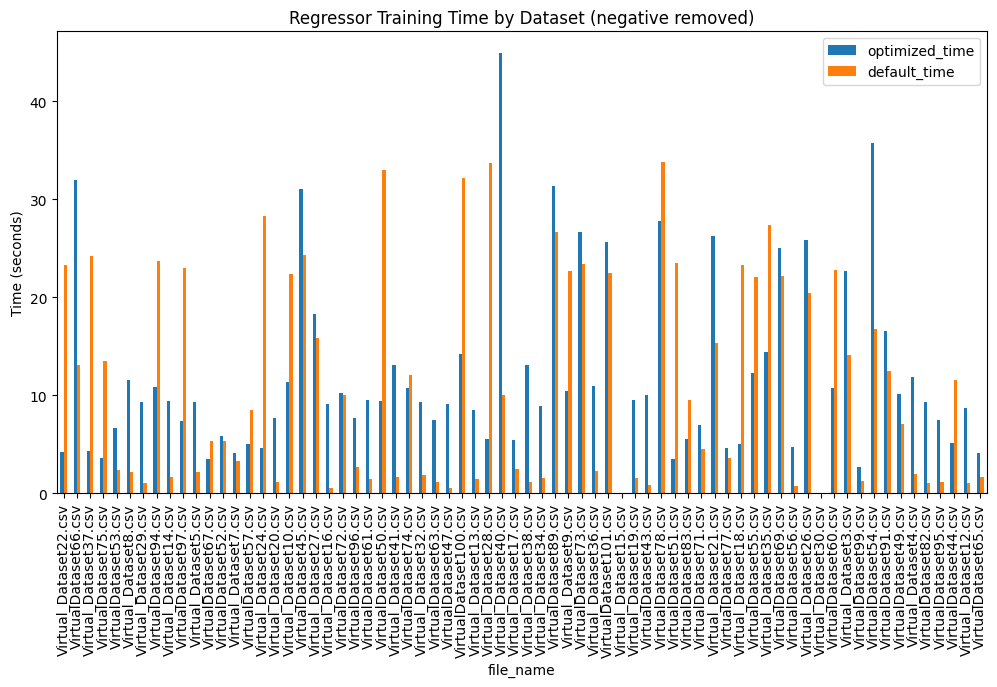

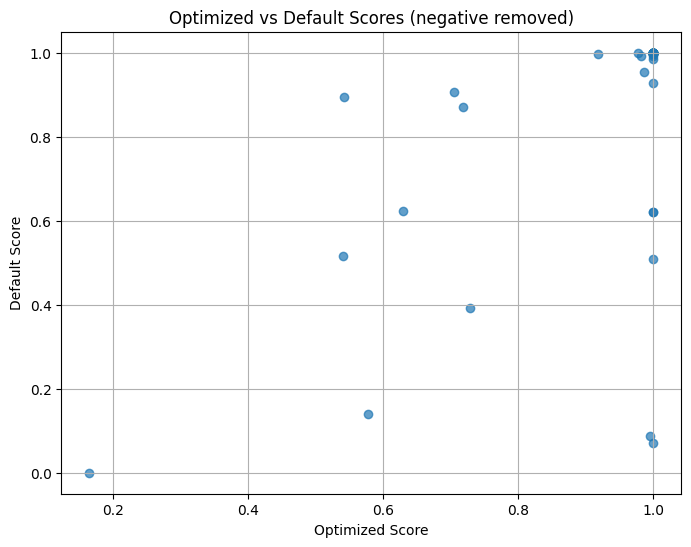

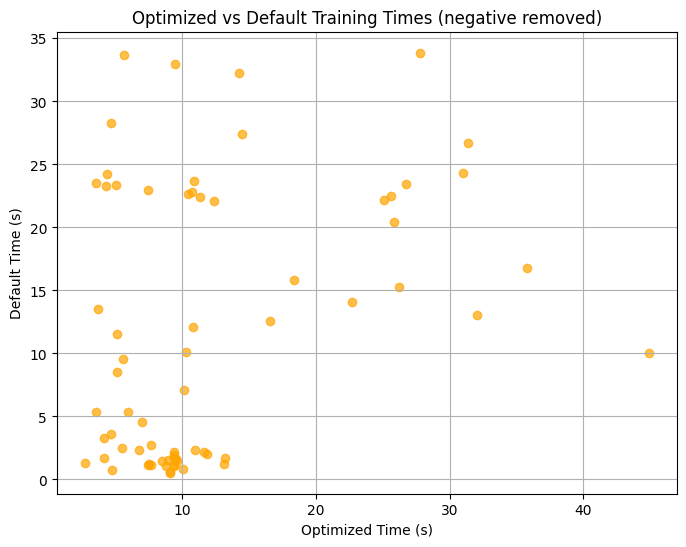

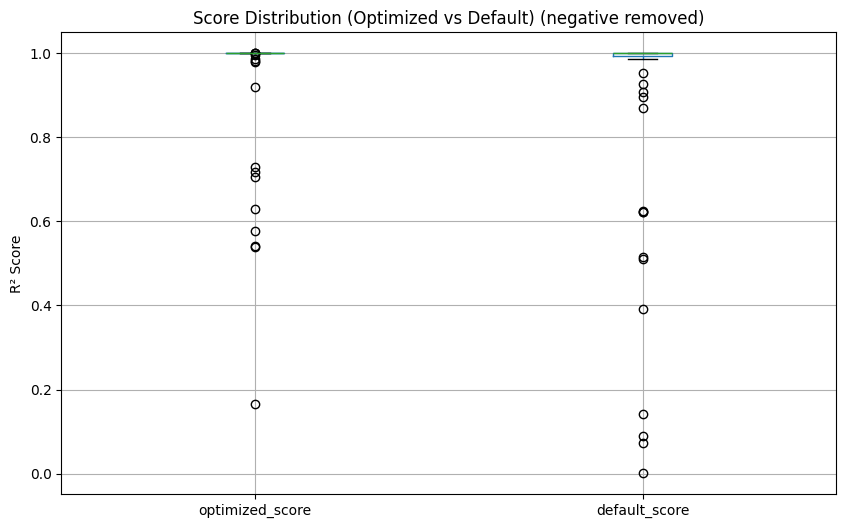

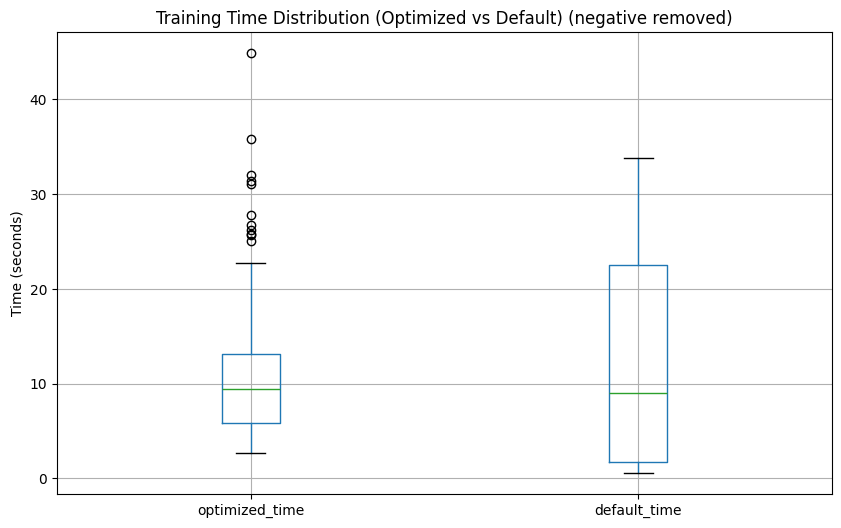

In [21]:

import matplotlib.pyplot as plt

# Remove the negative scores from both optimized and default, avoiding duplicate drops
indices_to_drop = set(optimized_scores[optimized_scores < 0].index) | set(default_scores[default_scores < 0].index)
filtered_df = hyper_big_df.drop(index=indices_to_drop)

# show how many were dropped per type of score
print(f"Dropped {(optimized_scores < 0).sum()} datasets due to negative scores in optimized optimization.")
print(f"Dropped {(default_scores < 0).sum()} datasets due to negative scores in default optimization.")

# show the mean scores and standart deviation after filtering
print(f"Mean Optimized Score (after filtering): {filtered_df['optimized_score'].mean():.4f} ± {filtered_df['optimized_score'].std():.4f}")
print(f"Mean Default Score (after filtering): {filtered_df['default_score'].mean():.4f} ± {filtered_df['default_score'].std():.4f}")

# Example: boxplot without the negative scores
filtered_df[['optimized_score', 'default_score']].boxplot()
plt.title('Score Distribution (Optimized vs Default) (negative removed)')
plt.ylabel('R² Score')
plt.show()

# Visualization for filtered_df

# Bar plot for scores
filtered_df[['optimized_score', 'default_score']].plot(
    kind="bar", figsize=(12,6), title="Regressor Scores by Dataset (negative removed)"
)
plt.ylabel("R² Score")
plt.show()

# Bar plot for training times
filtered_df[['optimized_time', 'default_time']].plot(
    kind="bar", figsize=(12,6), title="Regressor Training Time by Dataset (negative removed)"
)
plt.ylabel("Time (seconds)")
plt.show()

# Scatter plot to compare scores
plt.figure(figsize=(8,6))
plt.scatter(filtered_df['optimized_score'], filtered_df['default_score'], alpha=0.7)
plt.xlabel('Optimized Score')
plt.ylabel('Default Score')
plt.title('Optimized vs Default Scores (negative removed)')
plt.grid(True)
plt.show()

# Scatter plot to compare times
plt.figure(figsize=(8,6))
plt.scatter(filtered_df['optimized_time'], filtered_df['default_time'], alpha=0.7, color='orange')
plt.xlabel('Optimized Time (s)')
plt.ylabel('Default Time (s)')
plt.title('Optimized vs Default Training Times (negative removed)')
plt.grid(True)
plt.show()

# Boxplot for scores
plt.figure(figsize=(10,6))
filtered_df[['optimized_score', 'default_score']].boxplot()
plt.title('Score Distribution (Optimized vs Default) (negative removed)')
plt.ylabel('R² Score')
plt.show()

# Boxplot for training times
plt.figure(figsize=(10,6))
filtered_df[['optimized_time', 'default_time']].boxplot()
plt.title('Training Time Distribution (Optimized vs Default) (negative removed)')
plt.ylabel('Time (seconds)')
plt.show()


In [15]:
# mean scores and times
mean_optimized_score = optimized_scores.mean()
mean_default_score = default_scores.mean()
mean_optimized_time = optimized_times.mean()
mean_default_time = default_times.mean()

print(f"Mean Optimized Score: {mean_optimized_score:.4f}")
print(f"Mean Default Score: {mean_default_score:.4f}")
print(f"Mean Optimized Training Time: {mean_optimized_time:.4f} seconds")
print(f"Mean Default Training Time: {mean_default_time:.4f} seconds")

# count of scores of 1.0
count_optimized_perfect = (optimized_scores == 1.0).sum()
count_default_perfect = (default_scores == 1.0).sum()

print(f"Count of Perfect Optimized Scores (1.0): {count_optimized_perfect}")
print(f"Count of Perfect Default Scores (1.0): {count_default_perfect}")

# count of scores greater than 0.5
count_optimized_above_50 = (optimized_scores > 0.5).sum()
count_default_above_50 = (default_scores > 0.5).sum()
print(f"Count of Optimized Scores > 0.5: {count_optimized_above_50}")
print(f"Count of Default Scores > 0.5: {count_default_above_50}")

# count of scores loss then 0
count_optimized_below_0 = (optimized_scores < 0).sum()
count_default_below_0 = (default_scores < 0).sum()
print(f"Count of Optimized Scores < 0: {count_optimized_below_0}")
print(f"Count of Default Scores < 0: {count_default_below_0}")

Mean Optimized Score: -72.4586
Mean Default Score: -5.5754
Mean Optimized Training Time: 13.0049 seconds
Mean Default Training Time: 94.0496 seconds
Count of Perfect Optimized Scores (1.0): 44
Count of Perfect Default Scores (1.0): 56
Count of Optimized Scores > 0.5: 67
Count of Default Scores > 0.5: 76
Count of Optimized Scores < 0: 23
Count of Default Scores < 0: 17


In [ ]:
# to the big_df, add a column indicating the sizte of the corresponidng dataset
big_df['dataset_size'] = big_df.index.map(lambda x: len(pd.read_csv(os.path.join(dataset_folder, x))))

In [ ]:
# sort big_df by dataset_size and print the first 10 and last 10 rows
sorted_df = big_df.sort_values(by='dataset_size')
print("Smallest 10 datasets:")
print(sorted_df.head(10).to_string(), "\n")
print("Largest 10 datasets:")
print(sorted_df.tail(10).to_string(), "\n")

Smallest 10 datasets:
                       optimized_time  optimized_score  default_time  default_score  dataset_size
file_name                                                                                        
VirtualDataset42.csv        67.688295        -0.168909    152.039691      -2.125242            10
VirtualDataset80.csv        66.685937         0.646949    276.320679       0.929495            10
VirtualDataset79.csv        64.600572        -0.328944    170.220675       0.089619            10
Virtual_Dataset31.csv       55.507706    -24345.823317    237.059858      -4.080132            10
VirtualDataset68.csv        51.338020        -9.134252    190.514188     -11.769315            10
VirtualDataset46.csv        54.342359         0.596278    239.422142      -0.457895            10
VirtualDataset87.csv        49.176257       -56.417954     38.357757       1.000000            10
VirtualDataset85.csv        49.614779        -7.491012    236.978713      -2.473230            1

In [ ]:
# calculate the correlation between dataset_size and optimized_score, default_score
correlation_optimized = big_df['dataset_size'].corr(big_df['optimized_score'])
correlation_default = big_df['dataset_size'].corr(big_df['default_score'])

print(f"Correlation between dataset size and optimized score: {correlation_optimized:.4f}")
print(f"Correlation between dataset size and default score: {correlation_default:.4f}")

Correlation between dataset size and optimized score: 0.0176
Correlation between dataset size and default score: 0.0153


In [14]:
import numpy as np
import random
from multiprocessing import Pool, cpu_count
from sklearn.model_selection import train_test_split
import time
import pandas as pd
import os

# Define parameter grid
param_grid = {
    'population_size': [50, 100, 200, 500],
    'generations': [20, 50, 100, 200],
    'tournament_size': [10, 20, 30],
    'stopping_criteria': [0.0, 0.01, 0.05],
    # 'const_range': [(-1., 1.), (-10., 10.), None],
    'init_depth': [(2, 4), (2, 5), (2, 6)],
    # 'init_method': ['half and half', 'grow', 'full'],
    # 'function_set': [('add', 'sub', 'mul', 'div'), ('add', 'sub', 'mul', 'div', 'sqrt', 'log')],
    # 'metric': ['mean absolute error', 'mse', 'rmse'],
    'parsimony_coefficient': [0.001, 0.01, 0.1], #"auto"
    # 'p_crossover': [0.6, 0.7, 0.8],
    # 'p_subtree_mutation': [0.05, 0.1, 0.2],
    # 'p_hoist_mutation': [0.01, 0.05, 0.1],
    # 'p_point_mutation': [0.01, 0.05, 0.1],
    # 'p_point_replace': [0.05, 0.1],
    'max_samples': [0.7, 0.8, 0.9, 1.0],
    # 'random_state': [42], # usually fixed for reproducibility
}

random.seed(42)
# Select a subset of files for tuning
# Filter out files with NaN values before sampling
valid_files = []
for file_path in files:
    df = pd.read_csv(os.path.join(dataset_folder, file_path))
    X = df.iloc[:, :-1]
    if not np.isnan(X.values).any():
        valid_files.append(file_path)

# Select a subset of valid files for tuning
tune_files = random.sample(valid_files, min(20, len(valid_files)))


def evaluate_params(params_with_idx):
    idx, params = params_with_idx
    print(f"Evaluating configuration {idx+1} ...", flush=True)
    scores = []
    times = []
    for file_path in tune_files:
        df = pd.read_csv(os.path.join(dataset_folder, file_path))
        X = df.iloc[:, :-1]
        y = df.iloc[:, -1]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        reg = SymbolicRegressor(**params, random_state=42, optimize_constants=True)
        start_time = time.time()
        reg.fit(X_train, y_train)
        elapsed_time = time.time() - start_time
        times.append(elapsed_time)
        score = reg.score(X_test, y_test)
        scores.append(score)
    print(f"Configuration {idx+1} done", flush=True)
    return np.mean(scores), np.mean(times), params

def random_param():
    return {k: random.choice(v) for k, v in param_grid.items()}

n_runs = 48
param_list = [(i, random_param()) for i in range(n_runs)]

with Pool(cpu_count()) as pool:
    results = pool.map(evaluate_params, param_list)

best_score, best_fitting_time, best_params = max(results, key=lambda x: x[0])

for i, (score, fitting_time, params) in enumerate(results):
    print(f"Iteration {i+1}: score={score:.4f}, params={params}")

print("Best parameters found:")
print(best_params)
print("Best mean R² score:", best_score)

Evaluating configuration 1 ...Evaluating configuration 2 ...Evaluating configuration 3 ...Evaluating configuration 4 ...Evaluating configuration 5 ...Evaluating configuration 7 ...Evaluating configuration 8 ...Evaluating configuration 6 ...Evaluating configuration 9 ...Evaluating configuration 10 ...Evaluating configuration 11 ...
Evaluating configuration 12 ...Evaluating configuration 15 ...Evaluating configuration 13 ...Evaluating configuration 14 ...

Evaluating configuration 16 ...














/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs

Configuration 16 done
Evaluating configuration 17 ...


/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs

Configuration 8 done
Evaluating configuration 18 ...


/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs

Configuration 10 done
Evaluating configuration 19 ...


/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs

Configuration 11 done
Evaluating configuration 20 ...


/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs

Configuration 15 done
Evaluating configuration 21 ...


/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs

Configuration 7 done
Evaluating configuration 22 ...


/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs

Configuration 18 done
Evaluating configuration 23 ...


/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs

Configuration 21 done
Evaluating configuration 24 ...


/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs

Configuration 5 done
Evaluating configuration 25 ...


/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs

Configuration 1 done
Evaluating configuration 26 ...


/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs

Configuration 23 done
Evaluating configuration 27 ...


/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs

Configuration 3 done
Evaluating configuration 28 ...


/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs

Configuration 26 done
Evaluating configuration 29 ...


/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")


Configuration 2 done
Evaluating configuration 30 ...


/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs

Configuration 19 done
Evaluating configuration 31 ...


/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs

Configuration 30 done
Evaluating configuration 32 ...


/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs

Configuration 20 done
Evaluating configuration 33 ...


/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs

Configuration 25 done
Evaluating configuration 34 ...


/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs

Configuration 32 done
Evaluating configuration 35 ...


/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs

Configuration 33 done
Evaluating configuration 36 ...


/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs

Configuration 31 done
Evaluating configuration 37 ...


/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs

Configuration 34 done
Evaluating configuration 38 ...


/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs

Configuration 36 done
Evaluating configuration 39 ...


/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")


Configuration 12 done
Evaluating configuration 40 ...


/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs

Configuration 37 done
Evaluating configuration 41 ...


/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs

Configuration 14 done
Evaluating configuration 42 ...


/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs

Configuration 29 done
Evaluating configuration 43 ...


/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs

Configuration 40 done
Evaluating configuration 44 ...


/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs

Configuration 41 done
Evaluating configuration 45 ...


/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs

Configuration 43 done
Evaluating configuration 46 ...


/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs

Configuration 46 done
Evaluating configuration 47 ...


/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")


Configuration 44 done
Evaluating configuration 48 ...


/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs

Configuration 22 done


/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")


Configuration 27 done


/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs

Configuration 9 done


/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs

Configuration 42 done


/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs

Configuration 45 done


/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs

Configuration 38 done


/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")


Configuration 17 done


/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs

Configuration 6 done


/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")


Configuration 35 done


/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs

Configuration 39 done


/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs

Configuration 28 done


/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs

Configuration 48 done


/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")


Configuration 4 done


/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs

Configuration 47 done


/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs

Configuration 13 done


/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs' works equivalently to '2-point' for method='lm'.
  result = least_squares(objective, initial_constants, method="lm", ftol=10e-4, gtol=10e-4, xtol=10e-4, jac="cs")
/home/fidelius/gplearn/gplearn/_program.py:542: UserWarning: jac='cs

Configuration 24 done
Iteration 1: score=-9247.6884, params={'population_size': 100, 'generations': 200, 'tournament_size': 10, 'stopping_criteria': 0.01, 'init_depth': (2, 6), 'parsimony_coefficient': 0.01, 'max_samples': 0.7}
Iteration 2: score=-39.5643, params={'population_size': 100, 'generations': 200, 'tournament_size': 20, 'stopping_criteria': 0.01, 'init_depth': (2, 4), 'parsimony_coefficient': 0.001, 'max_samples': 0.9}
Iteration 3: score=-166.1390, params={'population_size': 50, 'generations': 20, 'tournament_size': 20, 'stopping_criteria': 0.0, 'init_depth': (2, 5), 'parsimony_coefficient': 0.01, 'max_samples': 0.9}
Iteration 4: score=-65.4024, params={'population_size': 50, 'generations': 200, 'tournament_size': 30, 'stopping_criteria': 0.0, 'init_depth': (2, 5), 'parsimony_coefficient': 0.001, 'max_samples': 0.9}
Iteration 5: score=-54.3634, params={'population_size': 200, 'generations': 50, 'tournament_size': 30, 'stopping_criteria': 0.0, 'init_depth': (2, 4), 'parsimony_

In [ ]:
# Best parameters found:
# {'population_size': 500, 'generations': 20, 'tournament_size': 10, 'stopping_criteria': 0.01, 'init_depth': (2, 4), 'parsimony_coefficient': 0.01, 'max_samples': 0.9, optimized_constants: False}
# Best mean R² score: 0.6238109812849923

# Best parameters found:
# {'population_size': 500, 'generations': 20, 'tournament_size': 10, 'stopping_criteria': 0.01, 'init_depth': (2, 4), 'parsimony_coefficient': 0.01, 'max_samples': 0.9, optimized_constants: True}
# Best mean R² score: 0.15448339849810716